In [5]:
import pandas as pd
import numpy as np
from datetime import datetime as DateTime
from datetime import timedelta as TimeDelta
from epiweeks import Year
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Configurando los estílos de los gráficos
plt.ioff()
sns.set_context('talk')
sns.set_style("whitegrid")

## Adquisición de Datos

In [6]:
defunciones_df = pd.read_csv('data/defunciones.csv')
defunciones_df['FECHA_FALLECIMIENTO'] = pd.to_datetime(defunciones_df['FECHA_FALLECIMIENTO'], infer_datetime_format=False, format='%m/%d/%Y')
defunciones_df.sort_values('FECHA_FALLECIMIENTO',  ascending=True, inplace=True)
defunciones_df.head()

,FECHA_CORTE,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,CLASIFICACION_DEF,DEPARTAMENTO,PROVINCIA,DISTRITO,UBIGEO,id_persona
12516,18/08/2021,2020-03-03,63,MASCULINO,Criterio SINADEF,SAN MARTIN,HUALLAGA,SAPOSOA,220401.0,36527082.0
89871,18/08/2021,2020-03-07,24,FEMENINO,Criterio SINADEF,LORETO,MAYNAS,FERNANDO LORES,160103.0,36853977.0
157471,18/08/2021,2020-03-11,78,FEMENINO,Criterio clÃ­nico,PIURA,PIURA,CURA MORI,200107.0,NaN
22333,18/08/2021,2020-03-14,4,MASCULINO,Criterio nexo epidemiolÃ³gico,LIMA,LIMA,LOS OLIVOS,150117.0,36614476.0
157523,18/08/2021,2020-03-14,8,MASCULINO,Criterio clÃ­nico,LORETO,REQUENA,REQUENA,160501.0,NaN


In [25]:
positivos_df = pd.read_csv('data/positivos_covid.csv', sep=',', usecols=['fecha_resultado','id_persona'])
positivos_df.dropna(inplace=True)
positivos_df['fecha_resultado'] = pd.to_datetime(positivos_df['fecha_resultado'], infer_datetime_format=False, format='%d/%m/%Y')
positivos_df.sort_values('fecha_resultado',  ascending=True, inplace=True)
positivos_df.tail()

,fecha_resultado,id_persona
2108299,2021-08-17,17622433.0
595042,2021-08-17,30514679.0
1834136,2021-08-17,14435434.0
377824,2021-08-17,23844715.0
1929481,2021-08-17,14856877.0


In [26]:
# Generando las semanas epidemológicas
weeks_2020 = list(Year(2020).iterweeks())
weeks_2021 = list(Year(2021).iterweeks())
weeks_all = weeks_2020 + weeks_2021

## Transformación de Datos

In [29]:
# Contamos los casos por semana
def generate_weekly_dataframe(source_df, column_name):
    first_date = source_df[column_name].iloc[0]
    last_date = source_df[column_name].iloc[-1]
    data = []

    for i in np.arange(0,len(weeks_all)):
        start_date = np.datetime64(weeks_all[i].startdate())
        end_date = np.datetime64(weeks_all[i].enddate())

        if(start_date < first_date):
            continue

        if(end_date > last_date):
            break

        data_df = source_df[(source_df[column_name] >= start_date) & (source_df[column_name] <= end_date)]
        y = len(data_df)

        gb = data_df.groupby(by=column_name).agg(['count'])
        
        item = {
            'date': end_date,
            'high': gb['id_persona'].max()[0],
            'low': gb['id_persona'].min()[0],
            'close': gb['id_persona'].iloc[-1]['count'],
            'count': y
        }

        data.append(item)

    return pd.DataFrame(data, columns=['date','high','low','close','count'])

In [30]:
weekly_cases = generate_weekly_dataframe(positivos_df,'fecha_resultado')
weekly_cases.head()

,date,high,low,close,count
0,2020-03-14,18,1,18,45
1,2020-03-21,59,18,29,259
2,2020-03-28,126,19,126,390
3,2020-04-04,816,117,816,1918
4,2020-04-11,1334,426,1334,6290


In [31]:
weekly_deaths = generate_weekly_dataframe(defunciones_df,'FECHA_FALLECIMIENTO')
weekly_deaths.head()

,date,high,low,close,count
0,2020-03-14,1,0,1,3
1,2020-03-21,6,4,4,30
2,2020-03-28,12,5,8,62
3,2020-04-04,56,17,56,223
4,2020-04-11,99,40,85,530


## Visualización de Datos

<Figure size 432x288 with 0 Axes>

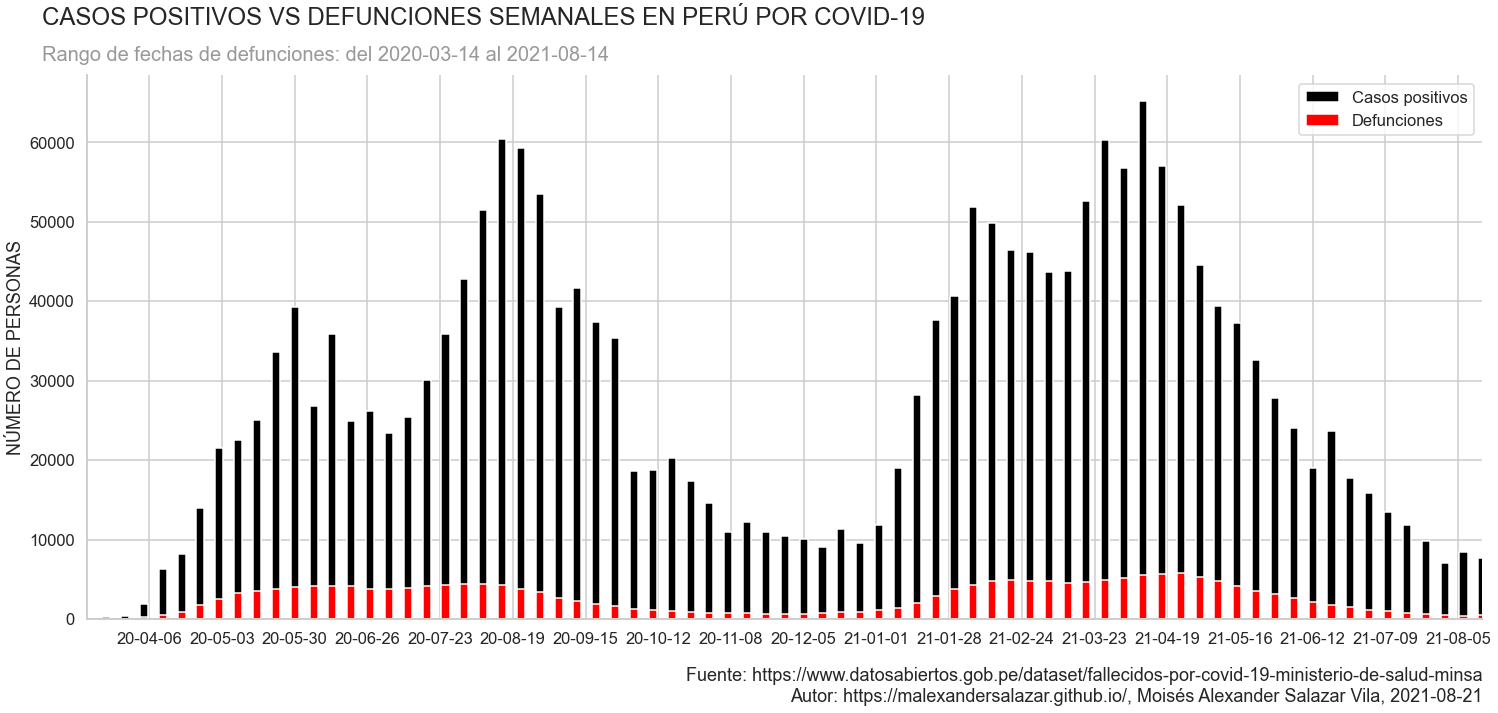

In [32]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'CASOS POSITIVOS VS DEFUNCIONES SEMANALES EN PERÚ POR COVID-19', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{weekly_deaths["date"].iat[0]:%Y-%m-%d}',f'{weekly_deaths["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%y-%m-%d")
locator = mdates.DayLocator(interval=27)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.bar(weekly_cases['date'], weekly_cases['count'], 3,color='#000', label='Casos positivos')
axs.bar(weekly_deaths['date'], weekly_deaths['count'], 3,color='#f00', label='Defunciones')

axs.set_xlim((weekly_deaths["date"].iat[0],weekly_deaths["date"].iat[-1]))
axs.set_ylabel('NÚMERO DE PERSONAS')

plt.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/COMPARATIVA.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [33]:
low_in_period = weekly_deaths['low'].rolling(10).min()
high_in_period = weekly_deaths['high'].rolling(10).max()
percentK = pd.Series((weekly_deaths['close'] - low_in_period) / (high_in_period - low_in_period) * 100, name='%K')
percentD = pd.Series(percentK.rolling(6).mean(), name='%D')
percentDn = pd.Series(percentD.rolling(6).mean(), name='%Dn')

<Figure size 432x288 with 0 Axes>

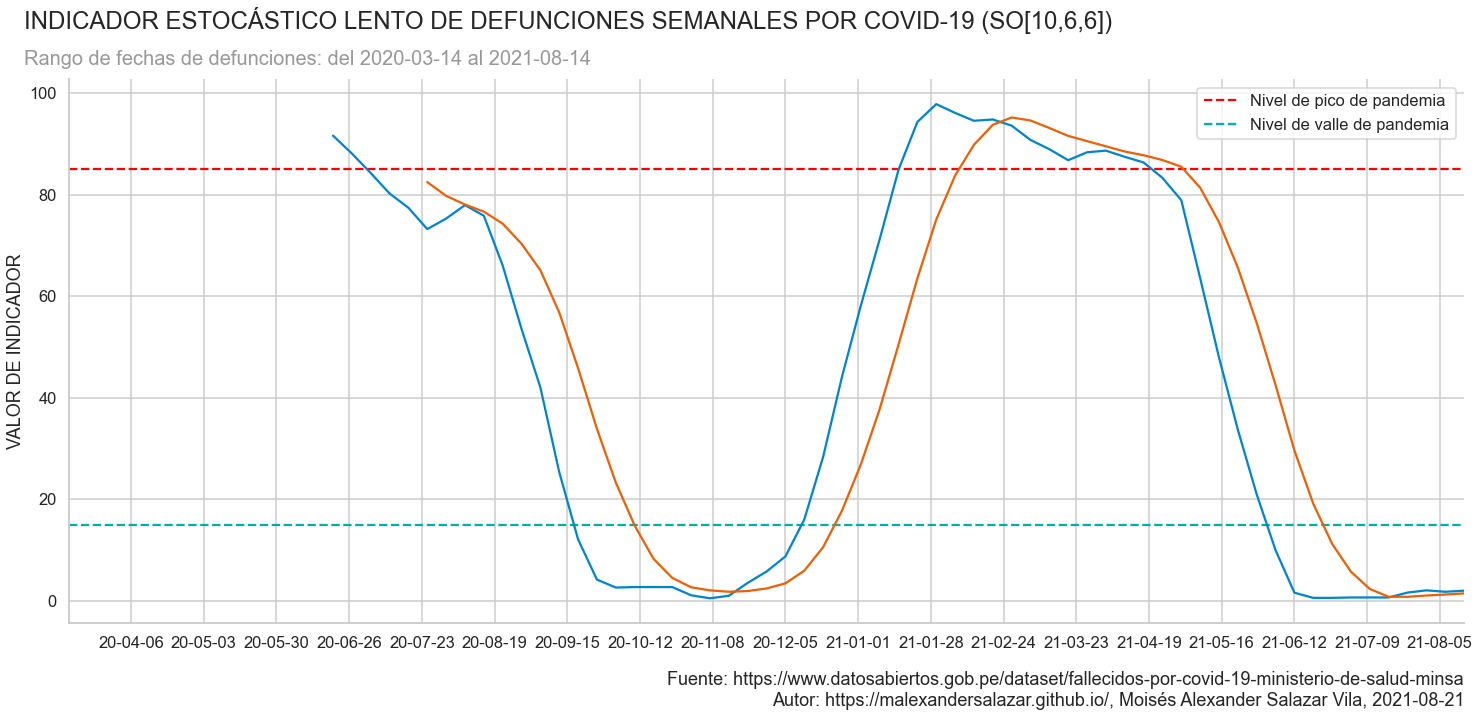

In [34]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR ESTOCÁSTICO LENTO DE DEFUNCIONES SEMANALES POR COVID-19 (SO[10,6,6])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{weekly_deaths["date"].iat[0]:%Y-%m-%d}',f'{weekly_deaths["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%y-%m-%d")
locator = mdates.DayLocator(interval=27)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly_deaths['date'], percentD, color='#0086CD')
axs.plot(weekly_deaths['date'], percentDn, color='#EC6106')
axs.hlines(85, weekly_deaths["date"].iat[0], weekly_deaths["date"].iat[-1], color='r', linestyles= 'dashed', label='Nivel de pico de pandemia')
axs.hlines(15, weekly_deaths["date"].iat[0], weekly_deaths["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de valle de pandemia')

axs.set_xlim((weekly_deaths["date"].iat[0],weekly_deaths["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/SO.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [35]:
weekly_delta = weekly_deaths['close'].diff()
weekly_up = weekly_delta.clip(lower=0)
weekly_down = -1*weekly_delta.clip(upper=0)

ema_up = weekly_up.ewm(com=14,adjust=False).mean()
ema_down = weekly_down.ewm(com=14,adjust=False).mean()
weekly_rs = ema_up/ema_down
weekly_rsi = 100-(100/(1+weekly_rs))
weekly_rsi.fillna(method='bfill',inplace=True)

<Figure size 432x288 with 0 Axes>

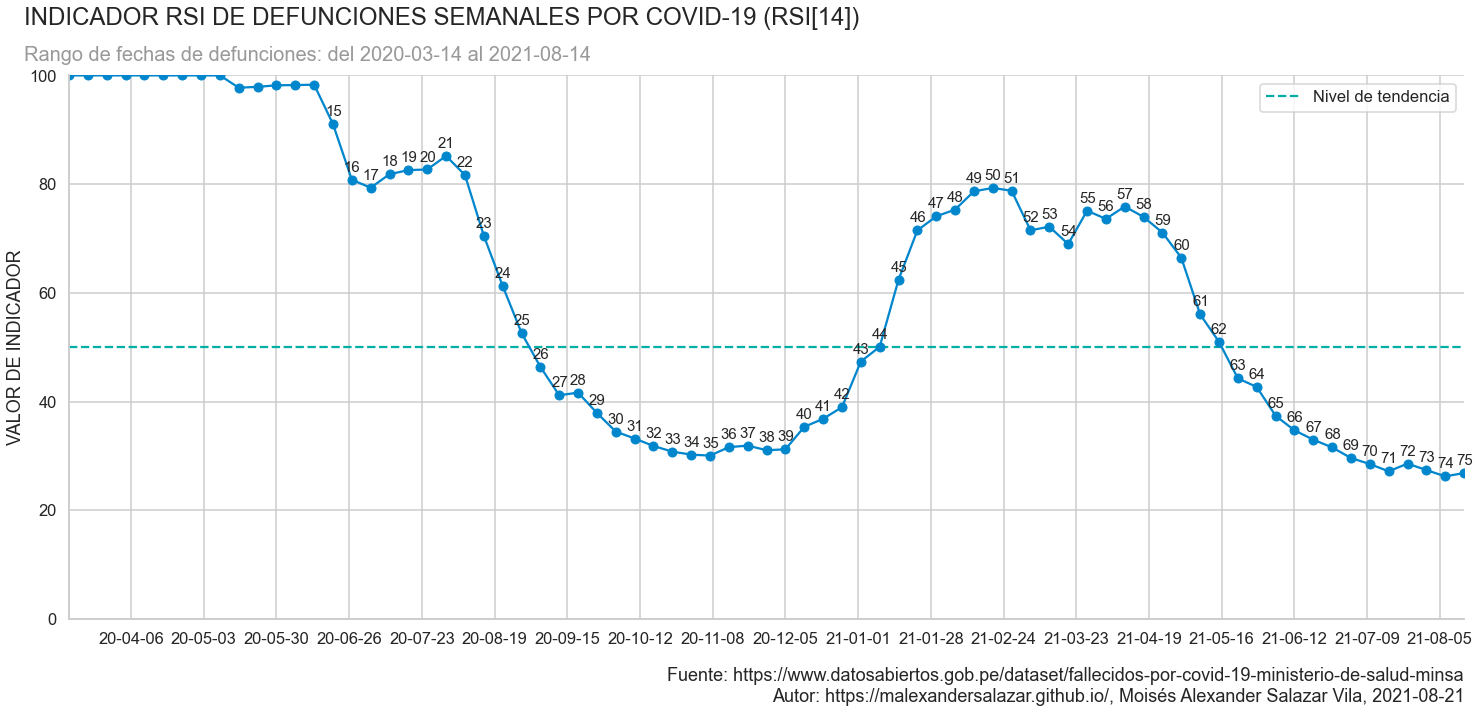

In [36]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR RSI DE DEFUNCIONES SEMANALES POR COVID-19 (RSI[14])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{weekly_deaths["date"].iat[0]:%Y-%m-%d}',f'{weekly_deaths["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%y-%m-%d")
locator = mdates.DayLocator(interval=27)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly_deaths['date'], weekly_rsi, 'o-', color='#0086CD')
axs.hlines(50, weekly_deaths["date"].iat[0], weekly_deaths["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de tendencia')

td = TimeDelta(days=3)

for i in range(14,len(weekly_deaths['date'])):
    axs.text(weekly_deaths['date'].iat[i]-td, weekly_rsi.iat[i] + 1.5, str(i+1), fontsize='small')

axs.set_ylim(0,100)
axs.set_xlim((weekly_deaths["date"].iat[0],weekly_deaths["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/RSI.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)